*This blog post benchmarks different compressors for use with genotype data from large-scale resequencing projects. TL;DR for speed you can't beat Blosc+LZ4, but Blosc+Zstd+Bitshuffle gives a very high compression ratio with good all-round performance.*

## Why do I care about compression?

Fast compression brings [interactive analysis of genome variation data](http://alimanfoo.github.io/2016/06/10/scikit-allel-tour.html) within reach of pretty much anyone with a computer. No need for a high-performance compute cluster. No need for a degree in software engineering. So it's not just a geeky obsession with making stuff go faster. It's also about making the data accessible to a broader audience and a deeper kind of exploration.

## About the data

The data used in this benchmark are genotype data from the [Ag1000G project phase 1 AR3 data release](https://www.malariagen.net/data/ag1000g-phase1-ar3) and can be downloaded via [FTP](ftp://ngs.sanger.ac.uk/production/ag1000g/phase1/AR3/variation/main/hdf5/). The goal of this benchmark is compare compression ratio and speed of compression and decompression for a variety of different compressors. For convenience I won't use all of the data, but will extract a sample of 2 million rows from a genotype array.

In [1]:
data_dir = '../assets/2016-09-21-genotype-compression-benchmark_data'

In [2]:
import h5py
import os
callset = h5py.File(os.path.join(data_dir, 'ag1000g.phase1.ar3.pass.3R.h5'), mode='r')
data = callset['3R/calldata/genotype'][5000000:7000000]

In uncompressed form, the genotype data are structured as a 3-dimensional array of 1-byte integers. The first dimension represents positions in the genome where genetic differences are observed between one or more individuals. The second dimension represents individuals (e.g., humans if you are doing human genetics, mosquitoes if you are doing mosquito genetics, etc.). The third dimension represents ploidy, which for organisms like humans or mosquitoes is always 2 (we each carry two genome copies, one from each of our parents).

In [3]:
data.dtype

dtype('int8')

In [4]:
data.shape

(2000000, 765, 2)

In [5]:
import humanize

def gnusize(nbytes, format='%.0f'):
    return humanize.naturalsize(nbytes, gnu=True, format=format)

print('benchmark data uncompressed size:', gnusize(data.nbytes, format='%.1f'))

benchmark data uncompressed size: 2.8G


The integer values in the array represent different DNA nucleotides (A, C, G, T, missing). However, rather than have a fixed code (0->A, 1->C, etc.), the encoding is based on comparison with a reference nucleotide sequence for the species being studied. A value of 0 means identical to the reference, a value of 1 or greater means different from the reference, and a negative value means missing. 

Because most individuals within a species share much of their DNA sequence in common with each other, genotype data are generally very sparse, in the sense that the vast majority of values are zero (identical to the reference). This sparseness is the main reason why genotype data compress well. Also, for organisms like humans where genetic diversity is relatively low, almost all non-zero values are 1. For organisms like mosquitoes where diversity is higher, a larger fraction of values can be greater than 1, although the data are still very sparse. If we are dealing with nucleotide variation (as is the case here) the maximum value is 3.

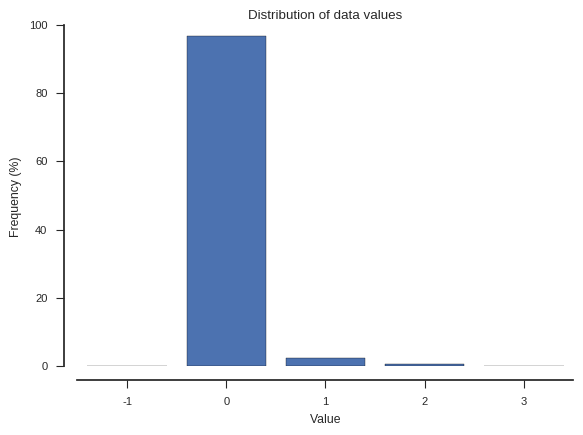

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('paper')

mn = data.min()
mx = data.max()
x = np.arange(mn, mx + 1)
# split bincount in two to avoid memory error
y = np.bincount(data[:1000000].reshape(-1) - mn)
y += np.bincount(data[1000000:2000000].reshape(-1) - mn)

fig, ax = plt.subplots()
sns.despine(ax=ax, offset=10)
ax.bar(x + .1, y * 100 / y.sum(), width=.8)
ax.set_xticks(x + .5)
ax.set_xticklabels(x)
ax.set_xlabel('Value')
ax.set_ylabel('Frequency (%)')
ax.set_title('Distribution of data values');

For the benchmark I'm going to store the data via [Zarr](http://zarr.readthedocs.io) which splits the data into chunks and compresses each chunk separately. Compressed data will be stored to and retrieved from main memory. 

For the purposes of this benchmark I'm going to chunk only along the first dimension. In practice a different chunk shape may be used depending on how the data will be accessed, however this blog post is focusing on comparing compressors and this simple chunk shape helps to provide a more direct comparison. 

I'm also going to use a relatively large chunk size - 16M - because I've found (during the process of setting up this benchmark) that this shows the compressors in their best light. Again, in practice, a different chunk size may be better, depending on how the data will be accessed. 

In [7]:
chunk_size = 2**24
print('uncompressed chunk size:', gnusize(chunk_size))
chunks = (int(chunk_size/(data.shape[1] * data.shape[2])), data.shape[1], data.shape[2])
print('chunk shape:', chunks)

uncompressed chunk size: 16M
chunk shape: (10965, 765, 2)


## About the compressors

The Python standard library provides three compression libraries: [Zlib](https://docs.python.org/3/library/zlib.html), [BZ2](https://docs.python.org/3/library/bz2.html) and [LZMA](https://docs.python.org/3/library/lzma.html). I'm including these in the benchmark for comparison, but although they provide good compression ratios, they are typically too slow for interactive data analysis. The main comparisons will be between different configurations of the [Blosc](http://blosc.org/) compression library. 

[Blosc](http://blosc.org/) is a meta-compressor which accelerates compression by using multiple threads and by splitting data into smaller blocks that fit well with CPU cache architecture. There are a number of different compression algorithms which can be used within Blosc, including LZ4, Zstandard, Zlib and BloscLZ. Blosc also provides hardware-optimized implementations of shuffle filters, which can improve compression ratio for some data. Because I am dealing with single-byte data, I am particularly interested in how the [bit-shuffle filter](https://github.com/kiyo-masui/bitshuffle) affects compression ratio and performance.

In [8]:
import zarr; print('zarr', zarr.__version__)
from zarr import blosc; print('blosc', blosc.__version__)

zarr 2.1.2
blosc 1.11.1


In [9]:
from zarr import Zlib, BZ2, LZMA, Blosc
from zarr.blosc import NOSHUFFLE, BITSHUFFLE
compressors = (
    None,
    Zlib(level=1),
    BZ2(level=1),
    LZMA(preset=1),
    Blosc(clevel=0, shuffle=NOSHUFFLE),
    Blosc(cname='snappy', clevel=9, shuffle=NOSHUFFLE),
    Blosc(cname='blosclz', clevel=1, shuffle=NOSHUFFLE),
    Blosc(cname='blosclz', clevel=5, shuffle=NOSHUFFLE),
    Blosc(cname='blosclz', clevel=9, shuffle=NOSHUFFLE),
    Blosc(cname='lz4', clevel=1, shuffle=NOSHUFFLE),
    Blosc(cname='lz4', clevel=5, shuffle=NOSHUFFLE),
    Blosc(cname='lz4', clevel=9, shuffle=NOSHUFFLE),
    Blosc(cname='lz4hc', clevel=1, shuffle=NOSHUFFLE),
    Blosc(cname='lz4hc', clevel=5, shuffle=NOSHUFFLE),
    Blosc(cname='zlib', clevel=1, shuffle=NOSHUFFLE),
    Blosc(cname='zlib', clevel=5, shuffle=NOSHUFFLE),
    Blosc(cname='zstd', clevel=1, shuffle=NOSHUFFLE),
    Blosc(cname='zstd', clevel=5, shuffle=NOSHUFFLE),
    Blosc(cname='snappy', clevel=9, shuffle=BITSHUFFLE),
    Blosc(cname='blosclz', clevel=1, shuffle=BITSHUFFLE),
    Blosc(cname='blosclz', clevel=5, shuffle=BITSHUFFLE),
    Blosc(cname='blosclz', clevel=9, shuffle=BITSHUFFLE),
    Blosc(cname='lz4', clevel=1, shuffle=BITSHUFFLE),
    Blosc(cname='lz4', clevel=5, shuffle=BITSHUFFLE),
    Blosc(cname='lz4', clevel=9, shuffle=BITSHUFFLE),
    Blosc(cname='lz4hc', clevel=1, shuffle=BITSHUFFLE),
    Blosc(cname='lz4hc', clevel=5, shuffle=BITSHUFFLE),
    Blosc(cname='zlib', clevel=1, shuffle=BITSHUFFLE),
    Blosc(cname='zlib', clevel=5, shuffle=BITSHUFFLE),
    Blosc(cname='zstd', clevel=1, shuffle=BITSHUFFLE),
    Blosc(cname='zstd', clevel=5, shuffle=BITSHUFFLE),
)

Note that ``NOSHUFFLE`` and ``BITSHUFFLE`` are numeric constants with values 0 and 2 respectively:

In [10]:
NOSHUFFLE

0

In [11]:
BITSHUFFLE

2

## Compression ratio

In [12]:
def calc_ratios():
    ratios = list()
    for compressor in compressors:
        z = zarr.array(data, chunks=chunks, compressor=compressor)
        ratio = z.nbytes / z.nbytes_stored
        ratios.append(ratio)
    return ratios


In [13]:
import os
ratios_fn = os.path.join(data_dir, 'ratios.npy')
if os.path.exists(ratios_fn):
    ratios = np.load(ratios_fn)
else:
    ratios = calc_ratios()
    np.save(ratios_fn, ratios)


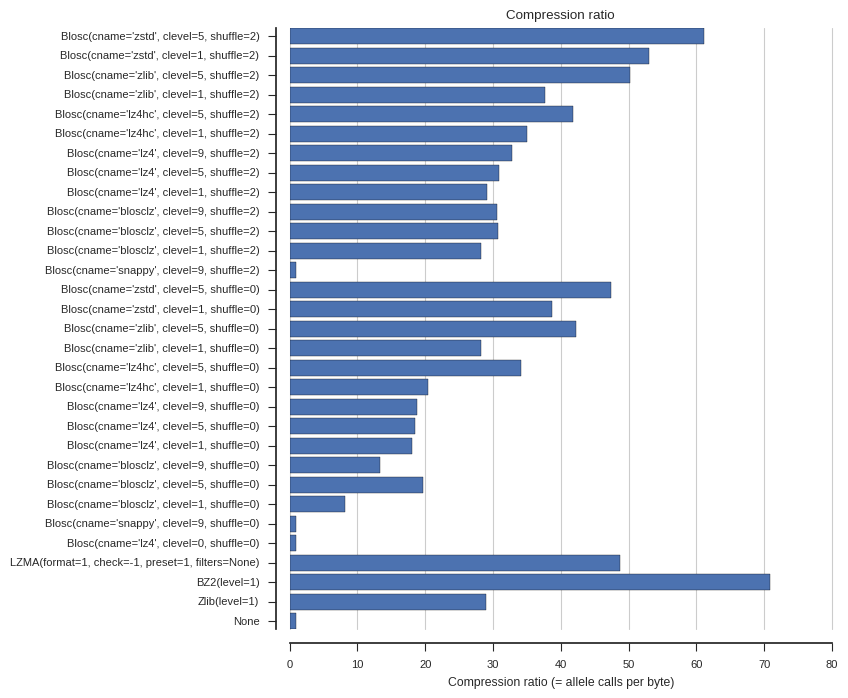

In [16]:
fig, ax = plt.subplots(figsize=(7, len(compressors) * .25))
sns.despine(ax=ax, offset=10)
ax.barh(bottom=np.arange(len(compressors)), width=ratios, height=.8)
ax.set_yticks(np.arange(len(compressors)) + .4)
ax.set_yticklabels([repr(c) for c in compressors])
ax.grid(axis='x')
ax.set_xlabel('Compression ratio (= allele calls per byte)')
ax.autoscale(axis='y')
ax.set_title('Compression ratio', va='bottom');

## Compression and decompression speed

In [17]:
import timeit

In [18]:
def bench_performance(repeat=10, number=1, blosc_nthreads=1):
    blosc.set_nthreads(blosc_nthreads)
    compress_times = list()
    decompress_times = list()
    for compressor in compressors:
        
        # benchmark compression
        z = zarr.empty_like(data, chunks=chunks, compressor=compressor)
        context = dict(z=z, data=data)
        compress_stmt = 'z[:] = data'
        t = timeit.Timer(stmt=compress_stmt, globals=context)
        c = t.repeat(repeat=repeat, number=number)
        compress_times.append(c)
        
        # benchmark decompression
        decompress_stmt = '_ = z[:]'
        t = timeit.Timer(stmt=decompress_stmt, globals=context)
        d = t.repeat(repeat=repeat, number=number)
        decompress_times.append(d)
        
    return compress_times, decompress_times

In [19]:
# this takes a long time - lots of replicates - so only run once and save results
times_fn = os.path.join(data_dir, 'times.npz')

if not os.path.exists(times_fn):
    compress_times, decompress_times = bench_performance(blosc_nthreads=1)
    mt_compress_times, mt_decompress_times = bench_performance(blosc_nthreads=8)
    np.savez(times_fn, 
             compress_times=compress_times, 
             decompress_times=decompress_times, 
             mt_compress_times=mt_compress_times,
             mt_decompress_times=mt_decompress_times)
else:
    times = np.load(times_fn)
    compress_times = times['compress_times']
    decompress_times = times['decompress_times']
    mt_compress_times = times['mt_compress_times']
    mt_decompress_times = times['mt_decompress_times']

In [20]:
def plot_speed(times, title, xlim=(0, 12100)):
    fig, ax = plt.subplots(figsize=(7, len(compressors) * .25))
    sns.despine(ax=ax, offset=10)
    
    # plot bars
    # convert time into speed (M/second)
    x = (data.nbytes / 2**20) / np.array(times)
    # use best run
    x_max = x.max(axis=1)
    ax.barh(bottom=np.arange(len(compressors)), width=x_max, height=.8)
    
    # plot data points
    y = np.arange(len(compressors)) + .4
    ax.plot(x, y, marker='o', linestyle=' ', color='k', markersize=2)
    
    ax.set_yticks(np.arange(len(compressors)) + .4)
    ax.set_yticklabels([repr(c) for c in compressors])
    ax.grid(axis='x')
    ax.set_xlabel('Speed (M/s)')
    ax.autoscale(axis='y', tight=True)
    ax.set_xlim(*xlim)
    ax.set_title(title, va='bottom')
    for i, (xi, ri) in enumerate(zip(x_max, ratios)):
        ax.annotate('%.1fX' % ri, xy=(xi, i+.4), xytext=(5, 0), 
                    textcoords='offset points', ha='left', va='center',
                    fontsize=8)

Below are several plots of compression and decompression speed. In the plots I've included the compression ratios as well as annotations (e.g., "61.1X") for easy reference. Note that ``clevel=0`` means no compression within Blosc, and ``None`` means no compressor at all (memory copy). 

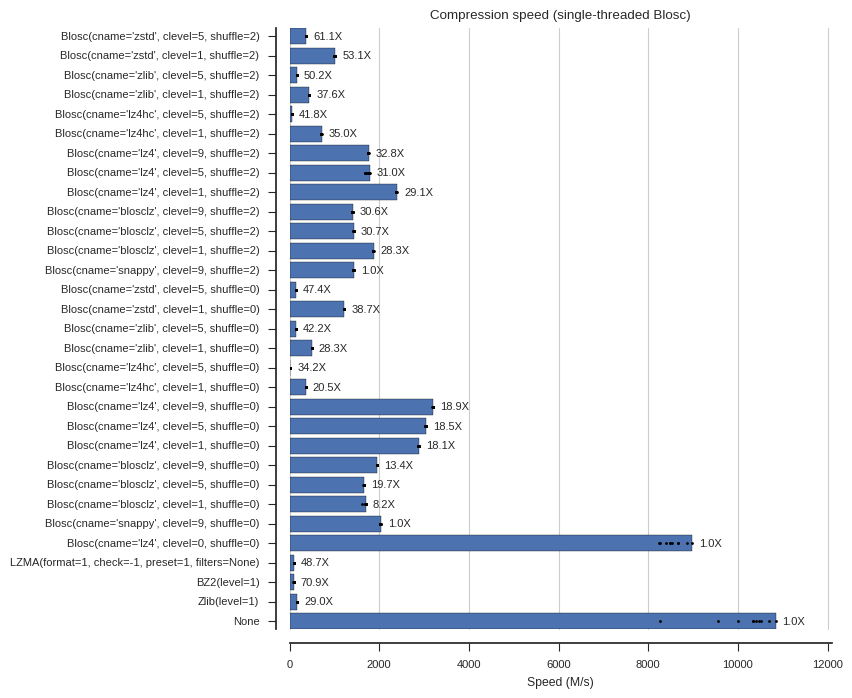

In [21]:
plot_speed(compress_times, 'Compression speed (single-threaded Blosc)')

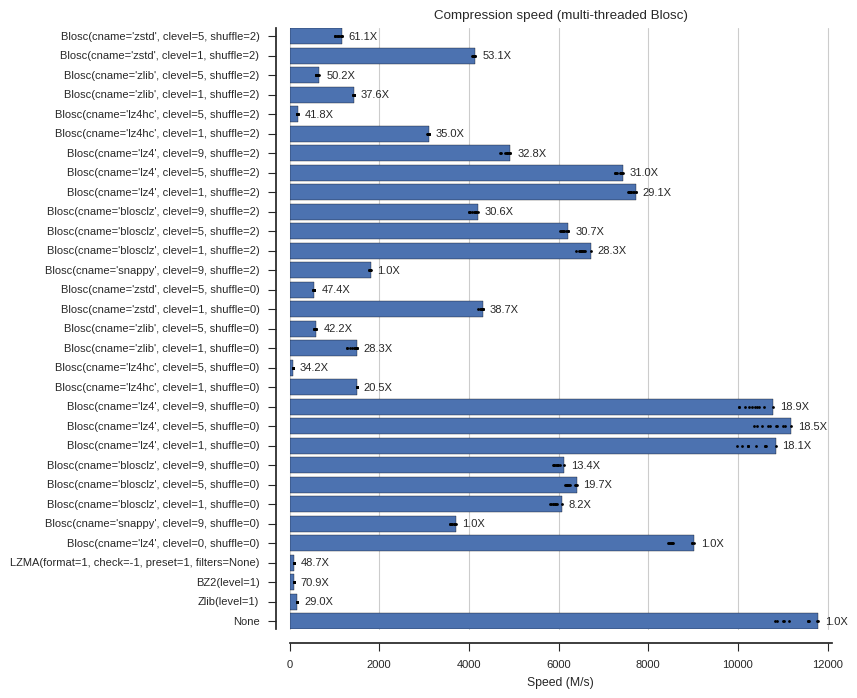

In [22]:
plot_speed(mt_compress_times, 'Compression speed (multi-threaded Blosc)')

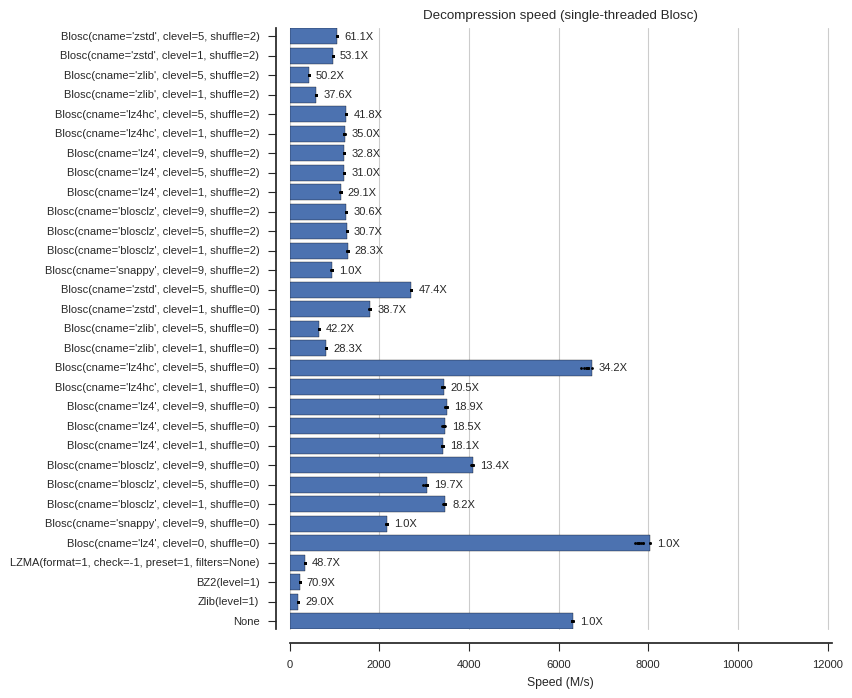

In [23]:
plot_speed(decompress_times, 'Decompression speed (single-threaded Blosc)')

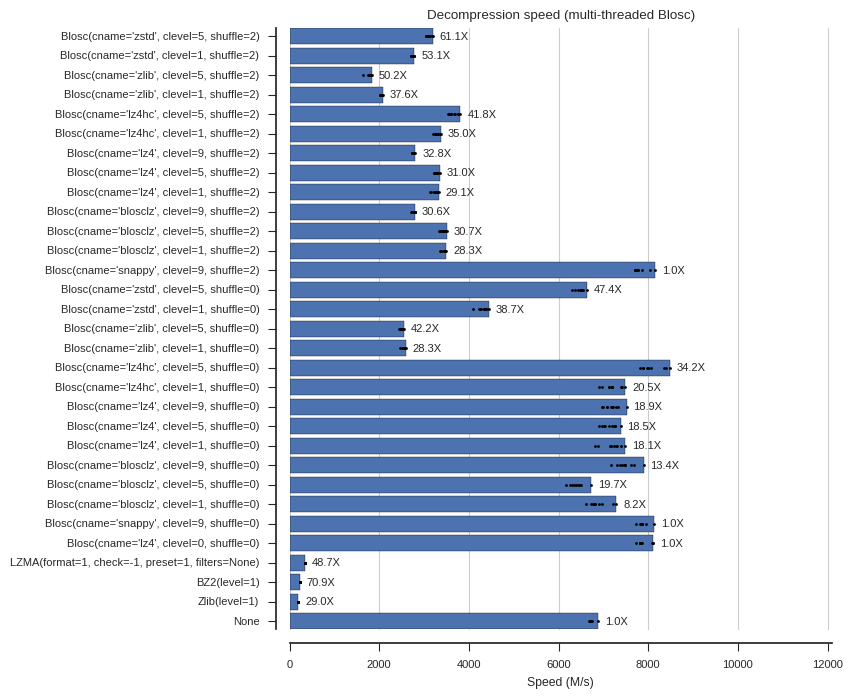

In [24]:
plot_speed(mt_decompress_times, 'Decompression speed (multi-threaded Blosc)')

## Summary

In [59]:
palette = sns.color_palette('Set1', n_colors=7)
#sns.palplot(palette);

colors = np.array([
    palette[0] if not isinstance(c, Blosc)
    else palette[1] if c.cname == b'snappy'
    else palette[2] if c.cname == b'blosclz'
    else palette[3] if c.cname == b'lz4'
    else palette[4] if c.cname == b'lz4hc'
    else palette[5] if c.cname == b'zlib'
    else palette[6] if c.cname == b'zstd'
    else 'k'
    for c in compressors
])

def plot_summary(ctimes, dtimes, xlim=(-200, 12200), ylim=(-200, 12200), annotate=[], 
                 title=None, alpha=1):
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.despine(ax=ax, offset=10)
    if title:
        ax.set_title(title, va='bottom')
    
    # use best run
    x = np.array(ctimes).min(axis=1)
    # convert time into speed (M/second)
    x = (data.nbytes / 2**20) / x
    # use best run
    y = np.array(dtimes).min(axis=1)
    # convert time into speed (M/second)
    y = (data.nbytes / 2**20) / y
    s = np.array(ratios) * 5
    
    is_bitshuffle = np.array([isinstance(c, Blosc) and c.shuffle == BITSHUFFLE 
                              for c in compressors])
    bs_marker = 'h'
    ns_marker = 'o'
    ax.scatter(x[is_bitshuffle], y[is_bitshuffle], s[is_bitshuffle], color=colors[is_bitshuffle], 
               marker=bs_marker, alpha=alpha)
    ax.scatter(x[~is_bitshuffle], y[~is_bitshuffle], s[~is_bitshuffle], color=colors[~is_bitshuffle], 
               marker=ns_marker, alpha=alpha)
    
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_xlabel('Compression speed (M/s)')
    ax.set_ylabel('Decompression speed (M/s)')
    
    for i, (xi, yi, ri, c) in enumerate(zip(x, y, ratios, compressors)):
        if i in annotate:
            ax.annotate('%.1fX %r' % (ri, c), xy=(xi, yi), xytext=(25, 0), va='center', ha='left',
                        textcoords='offset points', arrowprops=dict(arrowstyle="wedge"), fontsize=8)
    
    # color legend
    import matplotlib.lines as mlines
    handles = [
        mlines.Line2D([], [], color=color, marker=ns_marker, linestyle=' ',
                      markersize=10, label=label, alpha=alpha)
        for color, label in zip(
            palette,
            ['other', 'blosc+snappy', 'blosc+blosclz', 'blosc+lz4', 'blosc+lz4hc', 'blosc+zlib', 'blosc+zstd']
        )
    ]
    handles += [
        mlines.Line2D([], [], color='k', marker=ns_marker, linestyle=' ',
                      markersize=10, label='NOSHUFFLE', alpha=alpha),
        mlines.Line2D([], [], color='k', marker=bs_marker, linestyle=' ',
                      markersize=10, label='BITSHUFFLE', alpha=alpha)
        
    ]
    handles += [
        mlines.Line2D([], [], color='k', marker=ns_marker, linestyle=' ',
                      markersize=np.sqrt(x*5), label='%sX compression ratio' % x, alpha=alpha)
        for x in [10, 20, 30, 40, 50]
        
    ]
    ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(1, 0), ncol=2)
    ax.grid(axis='both')


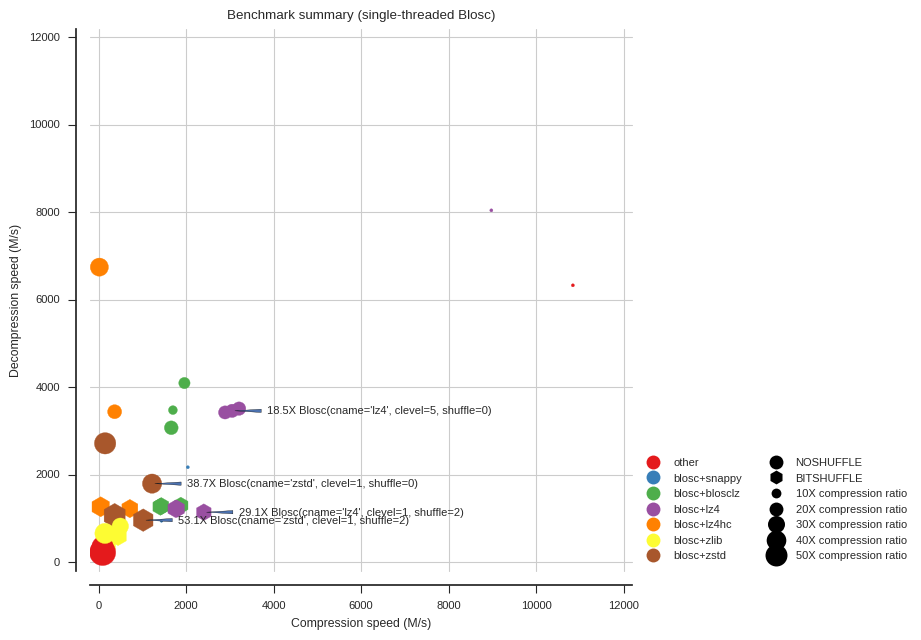

In [60]:
annotate = [10, 16, 22, 29]
plot_summary(compress_times, decompress_times, annotate=annotate, 
             title='Benchmark summary (single-threaded Blosc)')

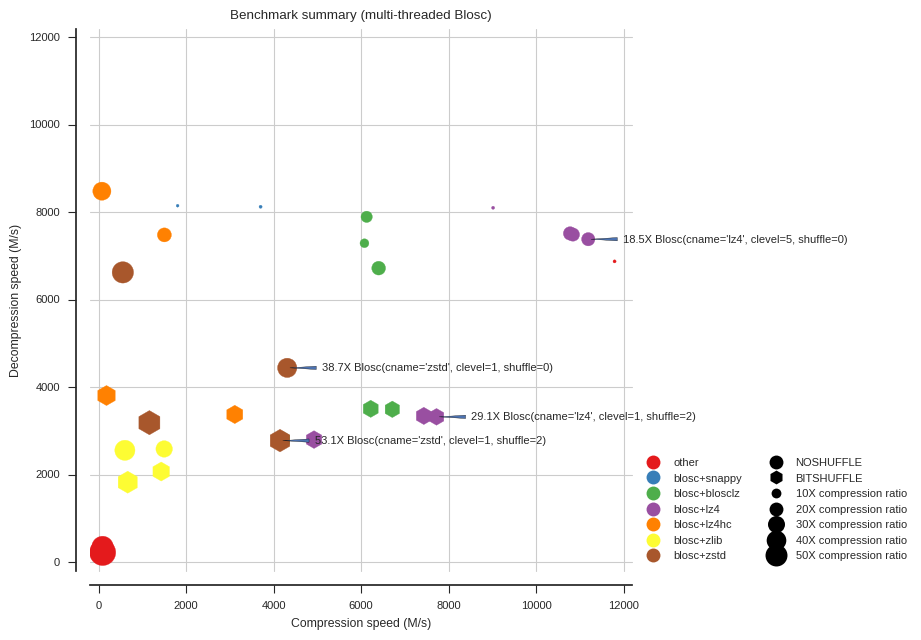

In [61]:
annotate = [10, 16, 22, 29]
plot_summary(mt_compress_times, mt_decompress_times, annotate=annotate, 
             title='Benchmark summary (multi-threaded Blosc)')

## Conclusions

* For maximum all-round speed, Blosc with LZ4 and no shuffle is ludicrous, compressing at 11G/s and decompressing at over 7G/s.
* For higher compression ratios, Blosc with Zstandard is excellent. Adding the bit-shuffle filter increases compression ratio even further to over 50X at a moderate cost to decompression speed.
* Using Blosc with multiple threads accelerates both compression and decompression, but larger (16M) chunk sizes were needed to see the benefits (see also below).

## Caveats

There are multiple interacting factors at work here, including data, software and hardware. Your mileage may vary substantially. Running your own benchmark is highly recommended.

## Further reading

* [Blosc web site](http://www.blosc.org/)
* [Zstandard web site](http://facebook.github.io/zstd/)
* [Zstandard GitHub repo](https://github.com/facebook/zstd)
* [Bitshuffle GitHub repo](https://github.com/kiyo-masui/bitshuffle)
* [New "bitshuffle" filter](http://www.blosc.org/blog/new-bitshuffle-filter.html) - blog post by Francesc Alted with further benchmarks using the bit-shuffle filter
* [Zstd has just landed in Blosc](http://www.blosc.org/blog/zstd-has-just-landed-in-blosc.html) - blog post by Francesc Alted with further benchmarks using Zstandard
* [Zarr documentation](http://zarr.readthedocs.io)
* [*Anopheles gambiae* 1000 genomes project](http://www.malariagen.net/ag1000g)

## Post-script: system information

Run on a Dell Precision 5510...

In [28]:
!lscpu

Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                8
On-line CPU(s) list:   0-7
Thread(s) per core:    2
Core(s) per socket:    4
Socket(s):             1
NUMA node(s):          1
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 94
Stepping:              3
CPU MHz:               1200.000
BogoMIPS:              5613.52
Virtualisation:        VT-x
L1d cache:             32K
L1i cache:             32K
L2 cache:              256K
L3 cache:              8192K
NUMA node0 CPU(s):     0-7


In [29]:
# cpuinfo has some more information, but N.B. mistakenly reports L3 cache size as L2
import cpuinfo
cpuinfo.main()

Vendor ID: GenuineIntel
Hardware Raw: 
Brand: Intel(R) Xeon(R) CPU E3-1505M v5 @ 2.80GHz
Hz Advertised: 2.8000 GHz
Hz Actual: 2.8010 GHz
Hz Advertised Raw: (2800000000, 0)
Hz Actual Raw: (2801000000, 0)
Arch: X86_64
Bits: 64
Count: 8
Raw Arch String: x86_64
L2 Cache Size: 8192 KB
L2 Cache Line Size: 0
L2 Cache Associativity: 0
Stepping: 3
Model: 94
Family: 6
Processor Type: 0
Extended Model: 0
Extended Family: 0
Flags: 3dnowprefetch, abm, acpi, adx, aes, aperfmperf, apic, arat, arch_perfmon, avx, avx2, bmi1, bmi2, bts, clflush, clflushopt, cmov, constant_tsc, cx16, cx8, de, ds_cpl, dtes64, dtherm, dts, eagerfpu, epb, ept, erms, est, f16c, flexpriority, fma, fpu, fsgsbase, fxsr, hle, ht, hwp, hwp_act_window, hwp_epp, hwp_noitfy, ida, invpcid, lahf_lm, lm, mca, mce, mmx, monitor, movbe, mpx, msr, mtrr, nonstop_tsc, nopl, nx, pae, pat, pbe, pcid, pclmulqdq, pdcm, pdpe1gb, pebs, pge, pln, pni, popcnt, pse, pse36, pts, rdrand, rdseed, rdtscp, rep_good, rtm, sep, smap, smep, smx, ss, sse, ss

In [1]:
import sys
print(sys.version)

3.5.2 | packaged by conda-forge | (default, Jul 26 2016, 01:32:08) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]


In [4]:
from distutils import sysconfig
sysconfig.get_config_var('CC')

'gcc -pthread'

In [2]:
!gcc --version

gcc (Ubuntu 4.8.4-2ubuntu1~14.04.3) 4.8.4
Copyright (C) 2013 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



## Post-script: Blosc detailed benchmarks

In [30]:
import sys

def log(*msg):
    print(*msg, file=sys.stdout)
    sys.stdout.flush()

In [31]:
def bench_blosc(cname, clevel, shuffle, nthreads, chunk_size, block_size, repeat=5, force=False):
    fn = os.path.join(data_dir, 'bench_blosc.%s.%s.%s.%s.%s.%s.npz' % (cname, clevel, shuffle, nthreads, chunk_size, block_size))
    if force or not os.path.exists(fn):
        log('building', cname, clevel, shuffle, nthreads, chunk_size, block_size)
        
        # set number of threads
        blosc.set_nthreads(nthreads)
        
        # set block size
        os.environ['BLOSC_BLOCKSIZE'] = str(block_size)
            
        # set chunks
        chunks = (int(chunk_size/(data.shape[1] * data.shape[2])), data.shape[1], data.shape[2])
        
        # setup compressor
        compressor = Blosc(cname=cname, clevel=clevel, shuffle=shuffle)

        # benchmark compression ratio
        z = zarr.array(data, chunks=chunks, compressor=compressor)
        ratio = z.nbytes / z.nbytes_stored

        # benchmark compression
        z = zarr.empty_like(data, chunks=chunks, compressor=compressor)
        context = dict(z=z, data=data)
        compress_stmt = 'z[:] = data'
        t = timeit.Timer(stmt=compress_stmt, globals=context)
        compress_times = t.repeat(repeat=repeat, number=1)

        # benchmark decompression
        decompress_stmt = '_ = z[:]'
        t = timeit.Timer(stmt=decompress_stmt, globals=context)
        decompress_times = t.repeat(repeat=repeat, number=1)

        results = dict(ratio=ratio, compress_times=compress_times, decompress_times=decompress_times)
        np.savez(fn, **results)
    
    else:
        results = np.load(fn)
    
    return results


In [32]:
shuffle_labels = ['NOSHUFFLE', 'SHUFFLE', 'BITSHUFFLE']

### Chunk size

In [33]:
def plot_blosc_chunk_size(cname, clevel, shuffle, nthreads, chunk_sizes, block_size, ax=None):
    
    # setup data
    x = list()
    yr = list()  # compression ratio
    yc = list()  # compress speed
    yd = list()  # decompress speed
    for chunk_size in chunk_sizes:
        x.append(chunk_size)
        results = bench_blosc(cname, clevel, shuffle, nthreads, chunk_size, block_size)
        yr.append(int(results['ratio']))
        yc.append((data.nbytes / 2**20) / np.min(results['compress_times']))
        yd.append((data.nbytes / 2**20) / np.min(results['decompress_times']))
        
    if ax is None:
        fix, ax = plt.subplots()
        
    ax.set_title('cname=%s, clevel=%s, shuffle=%s, nthreads=%s, block_size=%s' %
                 (cname, clevel, shuffle_labels[shuffle], nthreads, gnusize(block_size)),
                 va='bottom', fontsize=12)
        
    sns.despine(ax=ax, offset=10)
    ax.plot(x, yc, marker='o', color=palette[0], label='compression')
    ax.plot(x, yd, marker='o', color=palette[2], label='decompression')
    ax.set_xscale('log', basex=2)
    ax.set_xlabel('Chunk size')
    ax.legend(loc='upper left')
    ax.set_ylabel('Speed (M/s)')
    ax.set_ylim(0, 15200)
    ax.grid(axis='both')

    ax = ax.twinx()
    sns.despine(ax=ax, offset=10, left=True, right=False)
    ax.plot(x, yr, marker='o', color=palette[1], label='compression ratio')
    ax.set_xlabel('Chunk size')
    ax.set_xticks(chunk_sizes)
    ax.set_xticklabels([gnusize(x) for x in chunk_sizes])
    ax.set_ylabel('Compression ratio')
    ax.set_ylim(0, 70)
    ax.legend(loc='upper right')
    
    
def fig_blosc_chunk_size(cname, clevel, shuffle, chunk_sizes, block_size):
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(1, 2, 1)
    plot_blosc_chunk_size(cname=cname, clevel=clevel, shuffle=shuffle, nthreads=1, 
                          block_size=block_size, chunk_sizes=chunk_sizes, ax=ax)
    ax.set_title('nthreads=1')
    ax = fig.add_subplot(1, 2, 2)
    plot_blosc_chunk_size(cname=cname, clevel=clevel, shuffle=shuffle, nthreads=8, 
                          block_size=block_size, chunk_sizes=chunk_sizes, ax=ax)
    ax.set_title('nthreads=8')
    fig.suptitle('cname=%s, clevel=%s, shuffle=%s, block_size=%s' %
                 (cname, clevel, shuffle_labels[shuffle], gnusize(block_size)),
                 va='bottom', fontsize=12)
    fig.tight_layout()

    

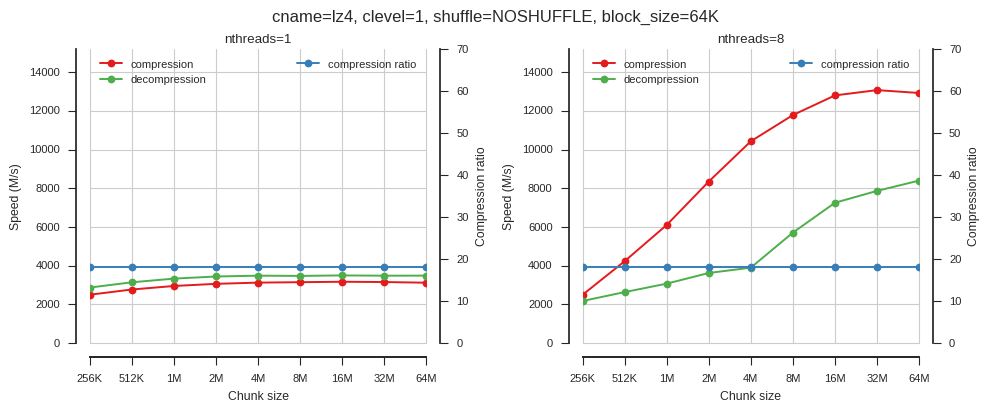

In [34]:
fig_blosc_chunk_size(cname='lz4', clevel=1, shuffle=0, block_size=2**16,
                     chunk_sizes=[2**x for x in range(18, 27)])

So when using single-threaded Blosc, chunk size doesn't matter much. When using multiple threads chunk size has a big effect.

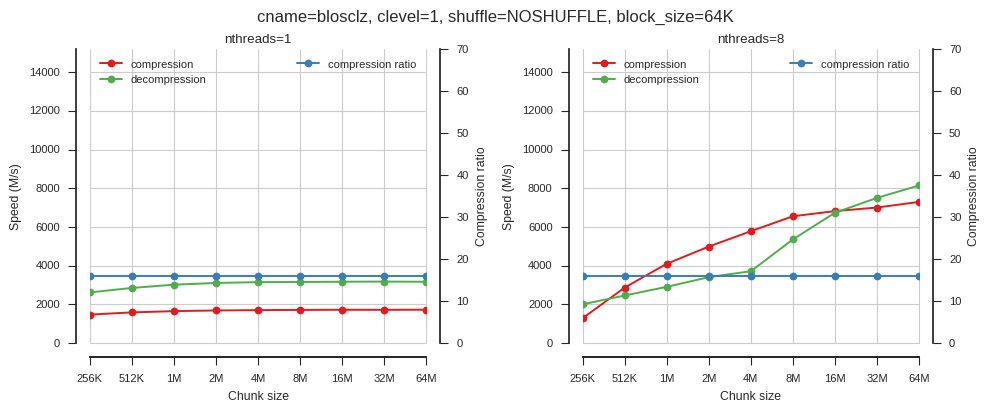

In [35]:
fig_blosc_chunk_size(cname='blosclz', clevel=1, shuffle=0, block_size=2**16,
                     chunk_sizes=[2**x for x in range(18, 27)])

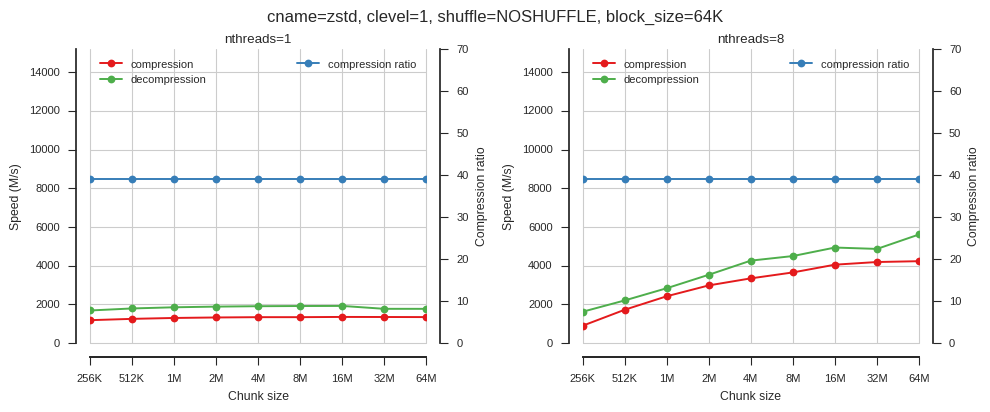

In [36]:
fig_blosc_chunk_size(cname='zstd', clevel=1, shuffle=0, block_size=2**16,
                     chunk_sizes=[2**x for x in range(18, 27)])

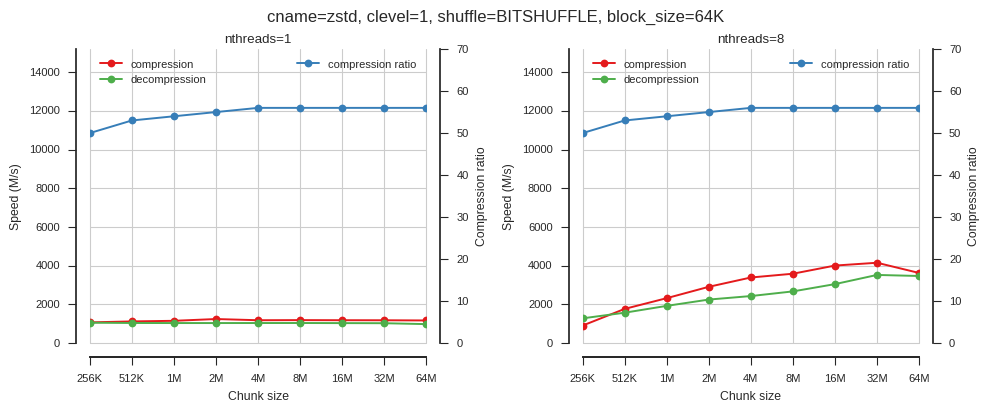

In [37]:
fig_blosc_chunk_size(cname='zstd', clevel=1, shuffle=2, block_size=2**16,
                     chunk_sizes=[2**x for x in range(18, 27)])

### Block size

In [38]:
def plot_blosc_block_size(cname, clevel, shuffle, nthreads, block_sizes, chunk_size, ax=None):
    
    # setup data
    x = list()
    yr = list()  # compression ratio
    yc = list()  # compress speed
    yd = list()  # decompress speed
    for block_size in block_sizes:
        x.append(block_size)
        results = bench_blosc(cname, clevel, shuffle, nthreads, chunk_size, block_size)
        yr.append(int(results['ratio']))
        yc.append((data.nbytes / 2**20) / np.min(results['compress_times']))
        yd.append((data.nbytes / 2**20) / np.min(results['decompress_times']))
        
    if ax is None:
        fix, ax = plt.subplots()
        
    ax.set_title('cname=%s, clevel=%s, shuffle=%s, nthreads=%s, chunk_size=%s' %
                 (cname, clevel, shuffle_labels[shuffle], nthreads, gnusize(chunk_size)),
                 va='bottom', fontsize=12)
        
    sns.despine(ax=ax, offset=10)
    ax.plot(x, yc, marker='o', color=palette[0], label='compression')
    ax.plot(x, yd, marker='o', color=palette[2], label='decompression')
    ax.set_xscale('log', basex=2)
    ax.set_xlabel('Block size')
    ax.legend(loc='upper left')
    ax.set_ylabel('Speed (M/s)')
    ax.set_ylim(0, 15200)
    ax.grid(axis='both')

    ax = ax.twinx()
    sns.despine(ax=ax, offset=10, left=True, right=False)
    ax.plot(x, yr, marker='o', color=palette[1], label='compression ratio')
    ax.set_xscale('log', basex=2)
    ax.set_xlabel('Block size')
    ax.set_xticks(block_sizes)
    ticklabels = [gnusize(x) for x in block_sizes]
    ax.set_xticklabels(ticklabels)
    ax.set_ylabel('Compression ratio')
    ax.set_ylim(0, 70)
    ax.legend(loc='upper right')
    
    
def fig_blosc_block_size(cname, clevel, shuffle, block_sizes, chunk_size):
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(1, 2, 1)
    plot_blosc_block_size(cname=cname, clevel=clevel, shuffle=shuffle, nthreads=1, 
                          block_sizes=block_sizes, chunk_size=chunk_size, ax=ax)
    ax.set_title('nthreads=1')
    ax = fig.add_subplot(1, 2, 2)
    plot_blosc_block_size(cname=cname, clevel=clevel, shuffle=shuffle, nthreads=8, 
                          block_sizes=block_sizes, chunk_size=chunk_size, ax=ax)
    ax.set_title('nthreads=8')
    fig.suptitle('cname=%s, clevel=%s, shuffle=%s, chunk_size=%s' %
                 (cname, clevel, shuffle_labels[shuffle], gnusize(chunk_size)),
                 va='bottom', fontsize=12)
    fig.tight_layout()
    
    

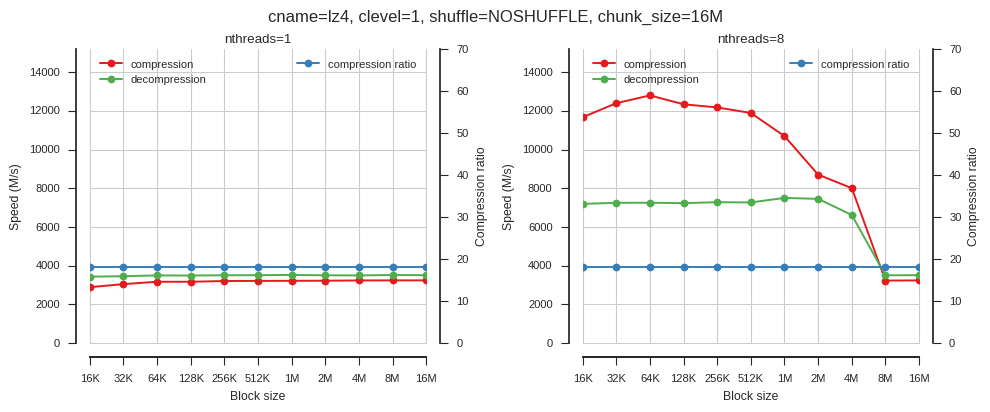

In [39]:
fig_blosc_block_size(cname='lz4', clevel=1, shuffle=0, chunk_size=2**24,
                      block_sizes=[2**x for x in range(14, 25)])

So block size matters but only when using multiple threads.

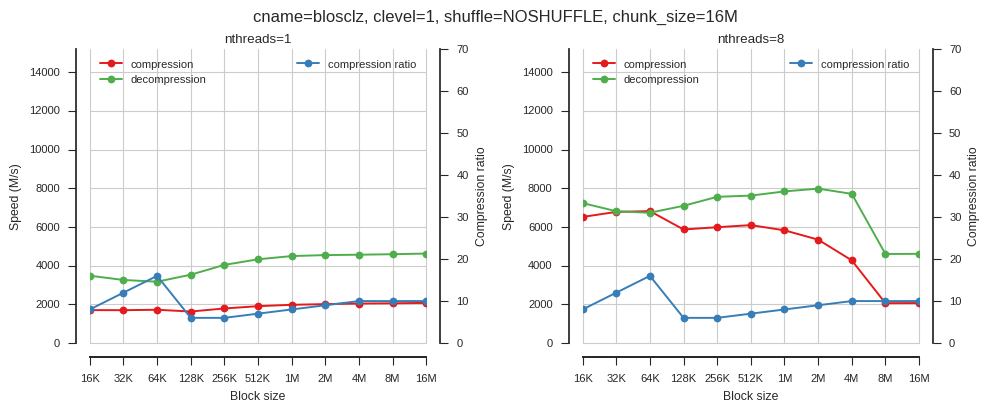

In [40]:
fig_blosc_block_size(cname='blosclz', clevel=1, shuffle=0, chunk_size=2**24,
                      block_sizes=[2**x for x in range(14, 25)])

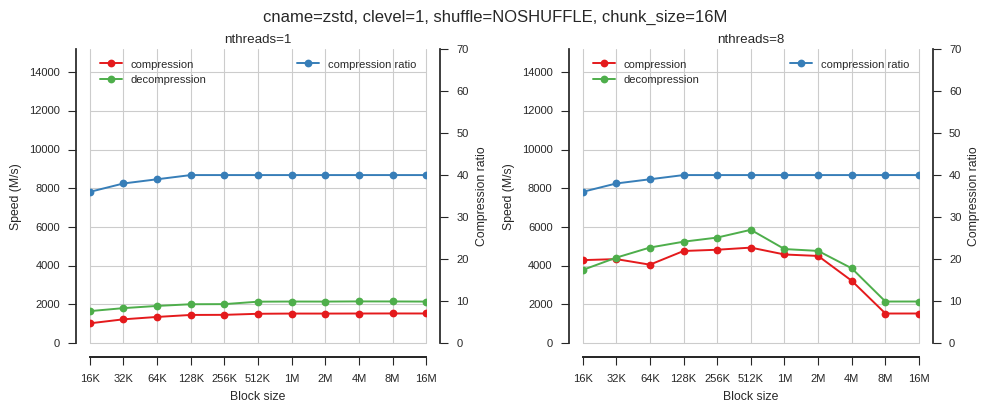

In [41]:
fig_blosc_block_size(cname='zstd', clevel=1, shuffle=0, chunk_size=2**24,
                      block_sizes=[2**x for x in range(14, 25)])

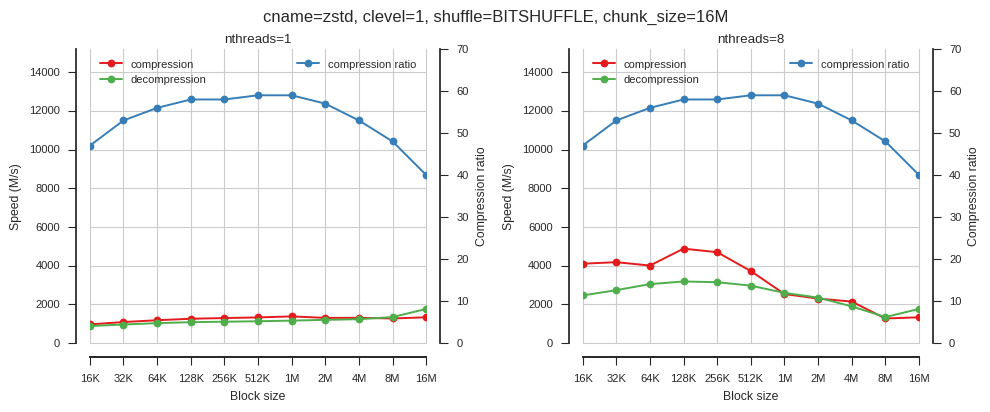

In [42]:
fig_blosc_block_size(cname='zstd', clevel=1, shuffle=2, chunk_size=2**24,
                      block_sizes=[2**x for x in range(14, 25)])

### Number of threads

In [55]:
def plot_blosc_nthreads(cname, clevel, shuffle, chunk_size, block_size, ax=None):
    
    # setup data
    x = list()
    yr = list()  # compression ratio
    yc = list()  # compress speed
    yd = list()  # decompress speed
    for nthreads in range(1, 9):
        x.append(nthreads)
        results = bench_blosc(cname, clevel, shuffle, nthreads, chunk_size, block_size)
        yr.append(int(results['ratio']))
        yc.append((data.nbytes / 2**20) / np.min(results['compress_times']))
        yd.append((data.nbytes / 2**20) / np.min(results['decompress_times']))
        
    if ax is None:
        fix, ax = plt.subplots()
        
    ax.set_title('cname=%s, clevel=%s, shuffle=%s, chunk_size=%s, block_size=%s' %
                 (cname, clevel, shuffle_labels[shuffle],  
                  gnusize(chunk_size),
                  gnusize(block_size)),
                 va='bottom', fontsize=12)
        
    sns.despine(ax=ax, offset=10)
    ax.plot(x, yc, marker='o', color=palette[0], label='compression')
    ax.plot(x, yd, marker='o', color=palette[2], label='decompression')
    ax.set_xlabel('Number of threads')
    ax.legend(loc='upper left')
    ax.set_ylabel('Speed (M/s)')
    ax.set_ylim(0, 15200)
    ax.grid(axis='both')

    ax = ax.twinx()
    sns.despine(ax=ax, offset=10, left=True, right=False)
    ax.plot(x, yr, marker='o', color=palette[1], label='compression ratio')
    ax.set_ylabel('Compression ratio')
    ax.set_ylim(0, 70)
    ax.legend(loc='upper right')
        
    
def fig_blosc_nthreads(cname, clevel, shuffle, block_size):
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(1, 2, 1)
    plot_blosc_nthreads(cname=cname, clevel=clevel, shuffle=shuffle, 
                        block_size=block_size, chunk_size=2**20, ax=ax)
    ax.set_title('chunk_size=%s' % gnusize(2**20))
    ax = fig.add_subplot(1, 2, 2)
    plot_blosc_nthreads(cname=cname, clevel=clevel, shuffle=shuffle, 
                        block_size=block_size, chunk_size=2**24, ax=ax)
    ax.set_title('chunk_size=%s' % gnusize(2**24))
    fig.suptitle('cname=%s, clevel=%s, shuffle=%s, block_size=%s' %
                 (cname, clevel, shuffle_labels[shuffle], gnusize(block_size)),
                 va='bottom', fontsize=12)
    fig.tight_layout()


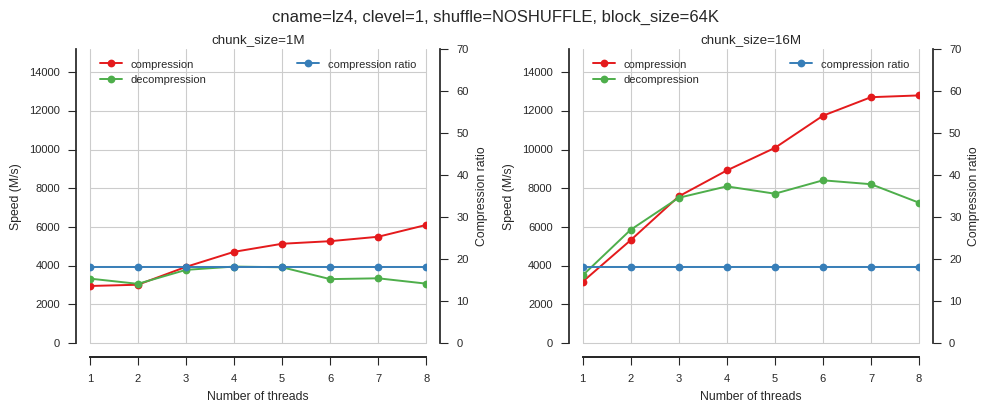

In [56]:
fig_blosc_nthreads(cname='lz4', clevel=1, shuffle=0, block_size=2**16)

Again this shows that multi-threading only provides good acceleration when block sizes are larger.

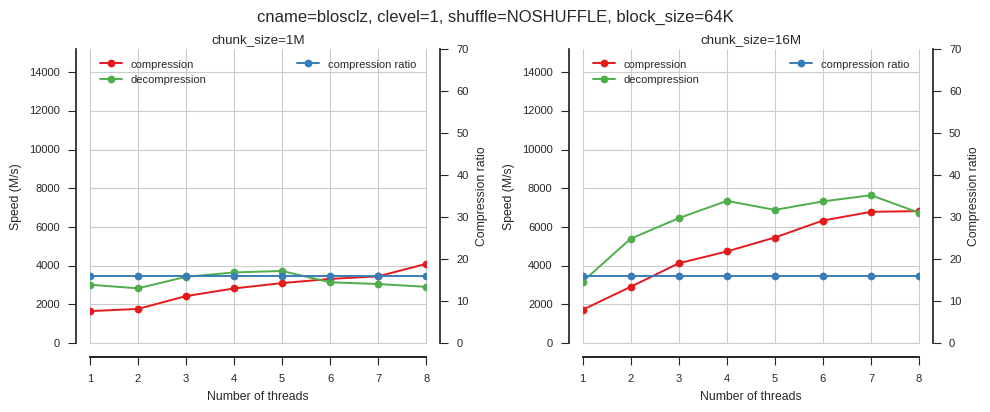

In [57]:
fig_blosc_nthreads(cname='blosclz', clevel=1, shuffle=0, block_size=2**16)

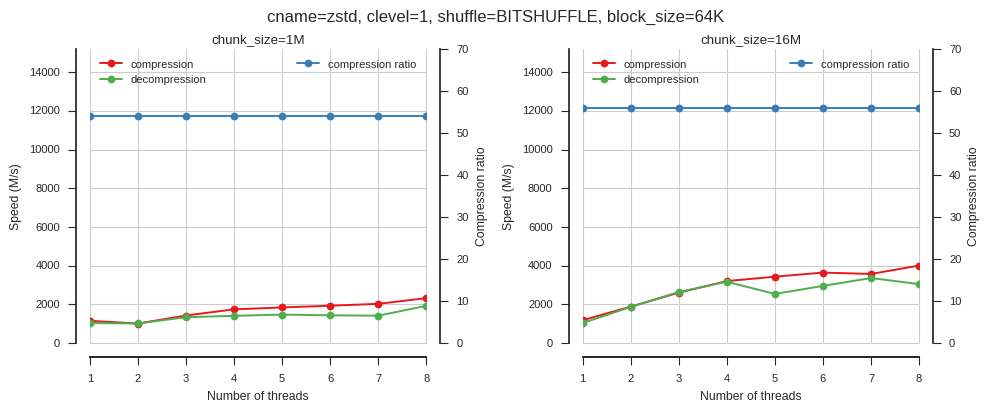

In [58]:
fig_blosc_nthreads(cname='zstd', clevel=1, shuffle=2, block_size=2**16)

### Compression level

In [47]:
def plot_blosc_clevel(cname, clevels, shuffle, nthreads, chunk_size, block_size, ax=None):
    
    # setup data
    x = list()
    yr = list()  # compression ratio
    yc = list()  # compress speed
    yd = list()  # decompress speed
    for clevel in clevels:
        x.append(clevel)
        results = bench_blosc(cname, clevel, shuffle, nthreads, chunk_size, block_size)
        yr.append(int(results['ratio']))
        yc.append((data.nbytes / 2**20) / np.min(results['compress_times']))
        yd.append((data.nbytes / 2**20) / np.min(results['decompress_times']))
        
    if ax is None:
        fix, ax = plt.subplots()
        
    ax.set_title('cname=%s, shuffle=%s, nthreads=%s, chunk_size=%s, block_size=%s' %
                 (cname, shuffle_labels[shuffle], nthreads,  
                  gnusize(chunk_size),
                  gnusize(block_size)),
                 va='bottom', fontsize=12)
        
    sns.despine(ax=ax, offset=10)
    ax.plot(x, yc, marker='o', color=palette[0], label='compression')
    ax.plot(x, yd, marker='o', color=palette[2], label='decompression')
    ax.set_xlabel('Compression level')
    ax.legend(loc='upper left')
    ax.set_ylabel('Speed (M/s)')
    ax.set_ylim(0, 15200)
    ax.set_xlim(-.1, 9.1)
    ax.set_xticks(clevels)
    ax.grid(axis='both')

    ax = ax.twinx()
    sns.despine(ax=ax, offset=10, left=True, right=False)
    ax.plot(x, yr, marker='o', color=palette[1], label='compression ratio')
    ax.set_ylabel('Compression ratio')
    ax.set_ylim(0, 70)
    ax.set_xlim(-.1, 9.1)
    ax.set_xticks(clevels)
    ax.legend(loc='upper right')
        
    
def fig_blosc_clevel(cname, clevels, shuffle, chunk_size, block_size):
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(1, 2, 1)
    plot_blosc_clevel(cname=cname, clevels=clevels, shuffle=shuffle, nthreads=1, 
                      block_size=block_size, chunk_size=chunk_size, ax=ax)
    ax.set_title('nthreads=1')
    ax = fig.add_subplot(1, 2, 2)
    plot_blosc_clevel(cname=cname, clevels=clevels, shuffle=shuffle, nthreads=8, 
                      block_size=block_size, chunk_size=chunk_size, ax=ax)
    ax.set_title('nthreads=8')
    fig.suptitle('cname=%s, shuffle=%s, chunk_size=%s, block_size=%s' %
                 (cname, shuffle_labels[shuffle], 
                  gnusize(chunk_size),
                  gnusize(block_size)),
                 va='bottom', fontsize=12)
    fig.tight_layout()


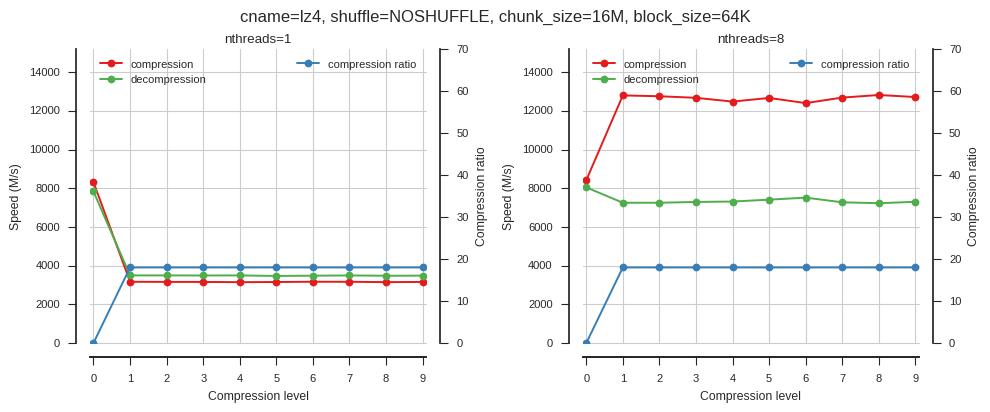

In [48]:
fig_blosc_clevel(cname='lz4', clevels=range(10), shuffle=0, chunk_size=2**24, block_size=2**16)

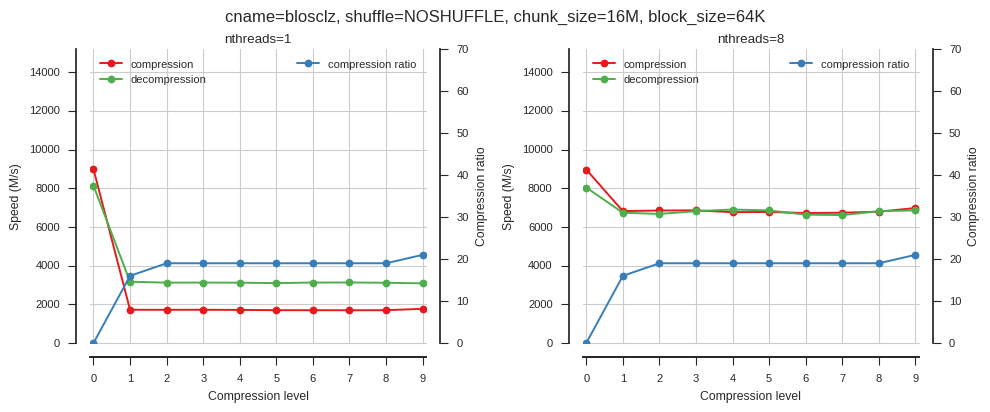

In [49]:
fig_blosc_clevel(cname='blosclz', clevels=range(10), shuffle=0, chunk_size=2**24, block_size=2**16)

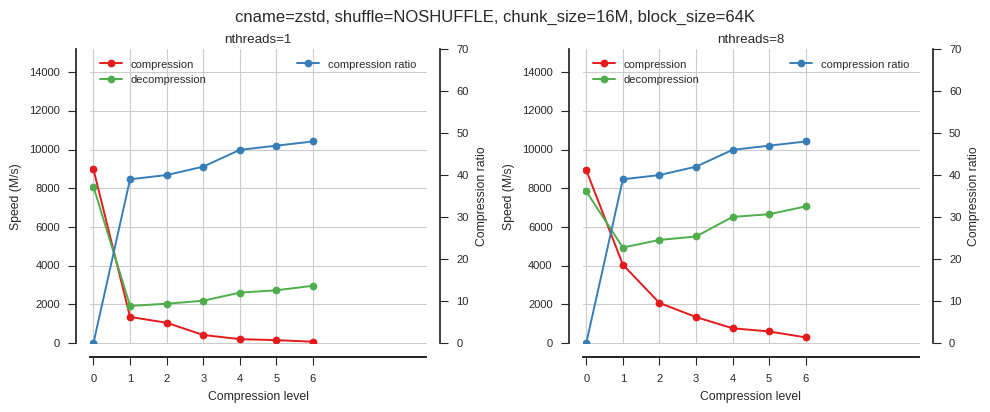

In [50]:
fig_blosc_clevel(cname='zstd', clevels=range(7), shuffle=0, chunk_size=2**24, block_size=2**16)

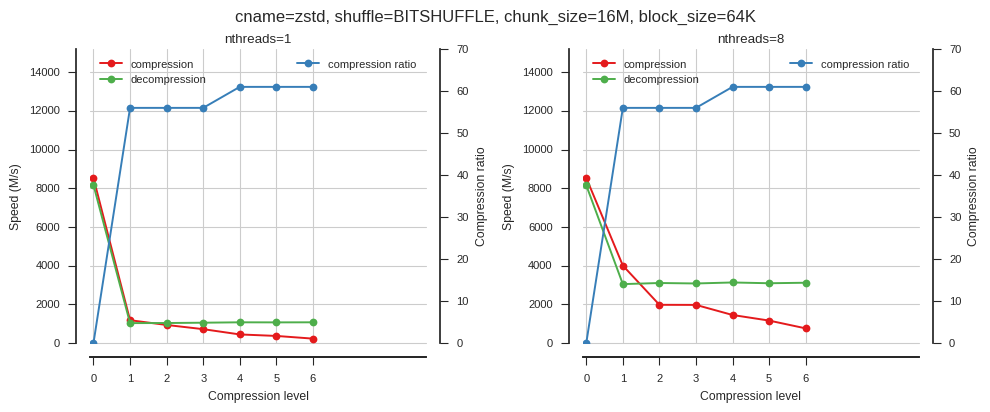

In [51]:
fig_blosc_clevel(cname='zstd', clevels=range(7), shuffle=2, chunk_size=2**24, block_size=2**16)